# Preprocessing UrbanSound8K Audio Files

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

import os
from os import listdir
from os.path import isfile, join
import glob
import pickle
import jams
import h5py
import extract_features as extract_features
import mel_features

import warnings
warnings.filterwarnings(action="ignore")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Load Metadata File

In [2]:
metadata = os.path.join("UrbanSound8K/metadata/UrbanSound8K.csv")

In [3]:
df = pd.read_csv(open(metadata,'rb'))

In [4]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


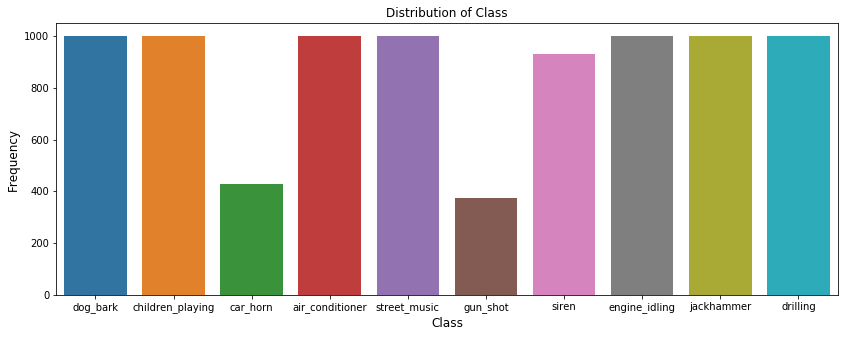

In [5]:
plt.figure(figsize =(14,5));
sns.countplot(x = 'class', data = df);
plt.title('Distribution of Class')
plt.xlabel("Class",fontsize = 12);
plt.ylabel("Frequency",fontsize = 12);
plt.show()

### Explore a Sample Audio File

In [6]:
from librosa import display
import librosa

import IPython.display as ipd
ipd.Audio('UrbanSound8K/audio/fold8/4918-3-3-0.wav')

In [7]:
sample_data, sampling_rate = librosa.load('UrbanSound8K/audio/fold1/7061-6-0-0.wav')

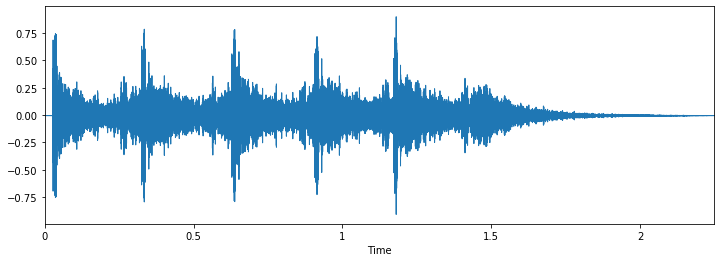

In [8]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(sample_data, sr=sampling_rate)

In [9]:
# Create a list of folder labels
fold_list = ((df['fold'].sort_values()).map(str)).unique().tolist()

# Create a list of the class labels
class_list = list(df['class'].unique())

#Folds
k_folds = 10

# Set Features Folder
features_folder = "UrbanSound8K/audio/"

In [10]:
# Let's grab a single audio file from each class
files = dict()
for i in range(len(class_list)):
    tmp = df[df['class'] == class_list[i]][:1].reset_index()
    path = 'UrbanSound8K/audio/fold{}/{}'.format(tmp['fold'][0], tmp['slice_file_name'][0])
    files[class_list[i]] = path

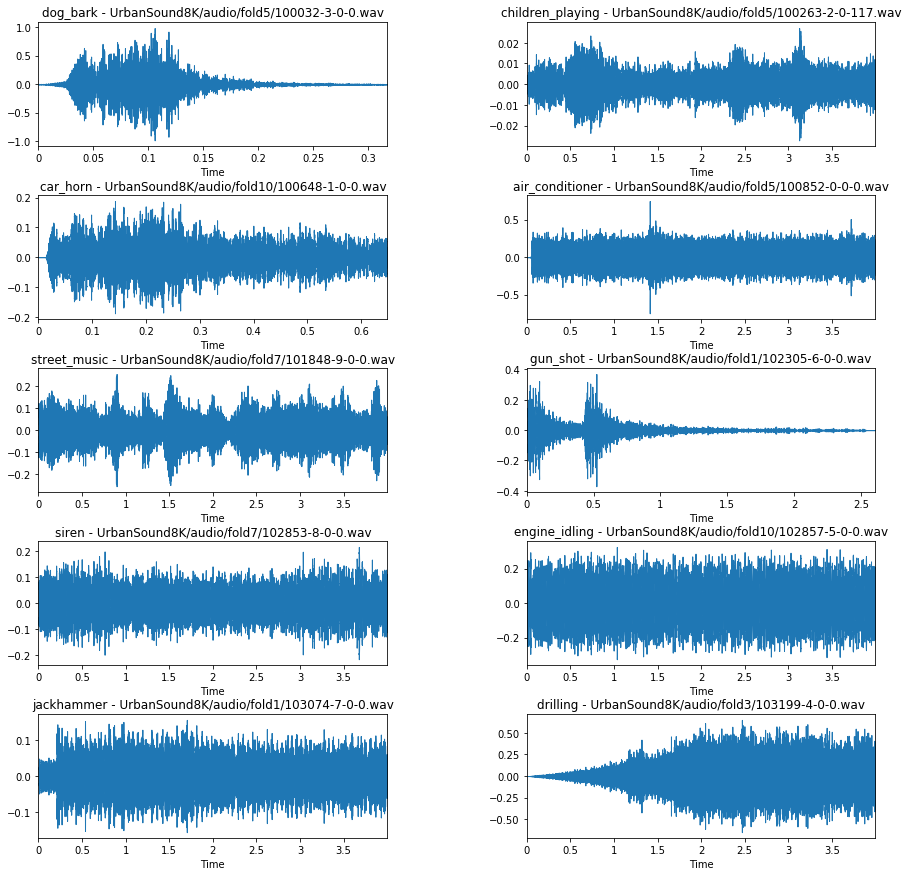

In [11]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(class_list):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label+' - '+ fn)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr= sample_rate)
plt.savefig('Class Samples.png')

Based on the above plots, it is obvious that the engine idling, jack hammer and airconditioner have similar waveplots.

## Create Audio Files List

In [7]:
for i in range(k_folds):
    fold_df = df[df['fold']==i+1]
    fold_df.reset_index(inplace=True)
    fold_df.iloc[[0]] 
    fold_no = fold_df[fold_df['end']-fold_df['start'] >= 1]
    fold_names = fold_no['slice_file_name'].tolist()
    fold_txt_path = 'UrbanSound8K/audio/fold'+ fold_list[i] + '/'
    files = [os.path.join(fold_txt_path,fold_names[f]) for f in range(len(fold_names))]
    file_name = 'fold_'+str(i+1)+'_txt.txt'
    file = open(os.path.join(fold_txt_path,file_name), "wb")
    pickle.dump(files,file)               
    file.close()

In [8]:
len(files)

803

## Extract Features

In [9]:
for i in range(k_folds):
    # Read the file list that has audio file names from each folder
    folder_features = 'fold'+str(i+1)+'_features.h5'
    folder_file = 'fold_'+str(i+1)+'_txt.txt'
    folder_path = 'UrbanSound8K/audio/fold'+ fold_list[i] + '/'
    with open(os.path.join(folder_path,folder_file),'rb') as f:
        mylist = pickle.load(f)
        
    files = []        
    for f in range(len(mylist)):
        files.append(mylist[f])
        
    # Extract features using VGGish encoding into fold<n>_features.h5 file 
    # with 'identifier', 'features'and 'features_z' columns
    extract_features.extract_vggish_embeddings(files,os.path.join('UrbanSound8K/audio/' + folder_features)) 
        
           
    # Write the extracted features to a file for each fold.
    fold_num = 'fold'+str(i+1)    
    fold_df = df[df['fold']==i+1]
    fold_df.reset_index(inplace=True)
    fold_df.iloc[[0]] 
    fold_no = fold_df[fold_df['end']-fold_df['start'] >= 1]
    features_file_name = fold_num + '_features.h5'
    new_feature_file = 'fold_'+str(i+1)+'_features.txt'
    
    # Read the .h5 file into fold_<n>_features.txt
    
    features_file = h5py.File(os.path.join(features_folder + features_file_name),  "r")
    
    features = list(features_file.values())[0]
    
    print('features')
    print(len(features))
    
    features[4]['features_z'][4]
    features[0]['features_z'][~np.all(features[0]['features_z'] == 0, axis=1)]
    
    classid = []
    fold = []
    
    for r in range(len(fold_no)):
        classid.append(int(fold_no.iloc[[r]]['classID']))
        fold.append(i+1)
    
    print('classid')
    print(len(classid))
    
    features_all = []


    for n in range(len(features)):    
        row_list = []
        row_list.append(features[n]['features_z'][~np.all(features[n]['features_z'] == 0, axis=1)])
        row_list.append(classid[n])
        row_list.append(files[n])
        row_list.append(fold[n])
        features_all.append(row_list)
        
    with open(os.path.join(features_folder,new_feature_file),'wb') as f:
        pickle.dump(features_all, f)

    


  0%|          | 0/829 [00:00<?, ?it/s]



Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold1/101415-3-0-2.wav features 4.0
0 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101415-3-0-2.wav
UrbanSound8K/audio/fold1/101415-3-0-3.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101415-3-0-3.wav
UrbanSound8K/audio/fold1/101415-3-0-8.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101415-3-0-8.wav
UrbanSound8K/audio/fold1/102106-3-0-0.wav features 1.64
UrbanSound8K/audio/fold1/102305-6-0-0.wav features 2.61
4 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 102305-6-0-0.wav
Ur

83 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 113205-5-1-4.wav
UrbanSound8K/audio/fold1/113205-5-1-5.wav features 4.0
84 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 113205-5-1-5.wav
UrbanSound8K/audio/fold1/113205-5-1-6.wav features 4.0
85 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 113205-5-1-6.wav
UrbanSound8K/audio/fold1/113205-5-1-7.wav features 4.0
86 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 113205-5-1-7.wav
UrbanSound8K/audio/fold1/113205-5-1-8.wav features 4.0
87 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 113205-5-1-8.wav
UrbanSound8K/audio/fold1/113205-5-1-9.wav features 4.0
88 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padd

 20%|█▉        | 165/829 [00:30<02:00,  5.50it/s]

UrbanSound8K/audio/fold1/135776-2-0-37.wav features 4.0
165 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 135776-2-0-37.wav
UrbanSound8K/audio/fold1/135776-2-0-40.wav features 4.0
166 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 135776-2-0-40.wav
UrbanSound8K/audio/fold1/135776-2-0-49.wav features 4.0
167 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 135776-2-0-49.wav
UrbanSound8K/audio/fold1/135776-2-0-50.wav features 4.0
168 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 135776-2-0-50.wav
UrbanSound8K/audio/fold1/135776-2-0-65.wav features 4.0
169 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 135776-2-0-65.wav
UrbanSound8K/audio/fold1/135776-2-0-85.wav features 4.0
170 could not broadcast 

Too little data. Padding with nan. 157867-8-0-11.wav
UrbanSound8K/audio/fold1/157867-8-0-12.wav features 4.0
257 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157867-8-0-12.wav
UrbanSound8K/audio/fold1/157867-8-0-13.wav features 4.0
258 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157867-8-0-13.wav
UrbanSound8K/audio/fold1/157867-8-0-14.wav features 4.0
259 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157867-8-0-14.wav
UrbanSound8K/audio/fold1/157867-8-0-15.wav features 4.0
260 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157867-8-0-15.wav
UrbanSound8K/audio/fold1/157867-8-0-16.wav features 4.0
261 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157867-8-0-16.wav
UrbanSound8K/audio/fold1/15

 40%|███▉      | 330/829 [00:55<01:26,  5.79it/s]

UrbanSound8K/audio/fold1/165067-2-0-35.wav features 4.0
330 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165067-2-0-35.wav
UrbanSound8K/audio/fold1/165067-2-0-56.wav features 4.0
331 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165067-2-0-56.wav
UrbanSound8K/audio/fold1/165067-2-0-72.wav features 4.0
332 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165067-2-0-72.wav
UrbanSound8K/audio/fold1/165067-2-0-9.wav features 4.0
333 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165067-2-0-9.wav
UrbanSound8K/audio/fold1/165067-2-0-91.wav features 4.0
334 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165067-2-0-91.wav
UrbanSound8K/audio/fold1/165642-4-0-0.wav features 4.0
335 could not broadcast inp

UrbanSound8K/audio/fold1/177621-0-0-27.wav features 4.0
421 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177621-0-0-27.wav
UrbanSound8K/audio/fold1/177621-0-0-31.wav features 4.0
422 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177621-0-0-31.wav
UrbanSound8K/audio/fold1/177621-0-0-35.wav features 4.0
423 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177621-0-0-35.wav
UrbanSound8K/audio/fold1/177621-0-0-46.wav features 4.0
424 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177621-0-0-46.wav
UrbanSound8K/audio/fold1/177621-0-0-47.wav features 4.0
425 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177621-0-0-47.wav
UrbanSound8K/audio/fold1/177621-0-0-48.wav features 4.0
426 could not broadcast 

 60%|█████▉    | 495/829 [01:21<00:56,  5.90it/s]

UrbanSound8K/audio/fold1/180937-7-3-29.wav features 4.0
495 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-7-3-29.wav
UrbanSound8K/audio/fold1/180937-7-3-3.wav features 4.0
496 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-7-3-3.wav
UrbanSound8K/audio/fold1/180937-7-3-30.wav features 4.0
497 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-7-3-30.wav
UrbanSound8K/audio/fold1/180937-7-3-31.wav features 4.0
498 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-7-3-31.wav
UrbanSound8K/audio/fold1/180937-7-3-32.wav features 4.0
499 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-7-3-32.wav
UrbanSound8K/audio/fold1/180937-7-3-33.wav features 4.0
500 could not broadcast in

Too little data. Padding with nan. 21684-9-0-25.wav
UrbanSound8K/audio/fold1/21684-9-0-30.wav features 4.0
592 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 21684-9-0-30.wav
UrbanSound8K/audio/fold1/21684-9-0-39.wav features 4.0
593 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 21684-9-0-39.wav
UrbanSound8K/audio/fold1/21684-9-0-5.wav features 4.0
594 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 21684-9-0-5.wav
UrbanSound8K/audio/fold1/21684-9-0-50.wav features 4.0
595 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 21684-9-0-50.wav
UrbanSound8K/audio/fold1/21684-9-0-7.wav features 4.0
596 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 21684-9-0-7.wav
UrbanSound8K/audio/fold1/22962-4-0-0.wav f

 80%|███████▉  | 660/829 [01:47<00:27,  6.07it/s]

UrbanSound8K/audio/fold1/46669-4-0-4.wav features 4.0
660 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 46669-4-0-4.wav
UrbanSound8K/audio/fold1/46669-4-0-45.wav features 4.0
661 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 46669-4-0-45.wav
UrbanSound8K/audio/fold1/46669-4-0-48.wav features 4.0
662 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 46669-4-0-48.wav
UrbanSound8K/audio/fold1/46669-4-0-49.wav features 4.0
663 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 46669-4-0-49.wav
UrbanSound8K/audio/fold1/46669-4-0-54.wav features 4.0
664 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 46669-4-0-54.wav
UrbanSound8K/audio/fold1/46669-4-0-61.wav features 4.0
665 could not broadcast input array f

Too little data. Padding with nan. 72261-3-0-23.wav
UrbanSound8K/audio/fold1/72261-3-0-27.wav features 4.0
753 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72261-3-0-27.wav
UrbanSound8K/audio/fold1/72261-3-0-6.wav features 4.0
754 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72261-3-0-6.wav
UrbanSound8K/audio/fold1/72579-3-0-0.wav features 4.0
755 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72579-3-0-0.wav
UrbanSound8K/audio/fold1/72579-3-0-2.wav features 4.0
756 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72579-3-0-2.wav
UrbanSound8K/audio/fold1/72579-3-0-3.wav features 4.0
757 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72579-3-0-3.wav
UrbanSound8K/audio/fold1/72579-3-0-4.wav featu

100%|█████████▉| 825/829 [02:22<00:00,  5.58it/s]

UrbanSound8K/audio/fold1/99180-9-0-36.wav features 4.0
825 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99180-9-0-36.wav
UrbanSound8K/audio/fold1/99180-9-0-48.wav features 4.0
826 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99180-9-0-48.wav
UrbanSound8K/audio/fold1/99180-9-0-49.wav features 4.0
827 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99180-9-0-49.wav
UrbanSound8K/audio/fold1/99180-9-0-7.wav features 4.0
828 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99180-9-0-7.wav


features
829
classid
829


  0%|          | 0/820 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold2/100652-3-0-0.wav features 4.0
0 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100652-3-0-0.wav
UrbanSound8K/audio/fold2/100652-3-0-1.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100652-3-0-1.wav
UrbanSound8K/audio/fold2/100652-3-0-2.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100652-3-0-2.wav
UrbanSound8K/audio/fold2/100652-3-0-3.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100652-3-0-3.wav
UrbanSound8K/audio/fold2/102858-5-0-0.wav features 4.0
4 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 102858-5-0-0.wav
UrbanSound8K/audio/fold2/102858

Too little data. Padding with nan. 123688-8-0-3.wav
UrbanSound8K/audio/fold2/123688-8-0-4.wav features 4.0
92 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 123688-8-0-4.wav
UrbanSound8K/audio/fold2/123688-8-0-5.wav features 4.0
93 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 123688-8-0-5.wav
UrbanSound8K/audio/fold2/123688-8-0-6.wav features 4.0
94 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 123688-8-0-6.wav
UrbanSound8K/audio/fold2/123688-8-0-7.wav features 4.0
95 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 123688-8-0-7.wav
UrbanSound8K/audio/fold2/123688-8-0-8.wav features 4.0
96 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 123688-8-0-8.wav
UrbanSound8K/audio/fold2/123688-8-0-9.wav f

 20%|██        | 164/820 [00:27<01:49,  5.97it/s]

UrbanSound8K/audio/fold2/147926-0-0-28.wav features 4.0
164 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 147926-0-0-28.wav
UrbanSound8K/audio/fold2/147926-0-0-34.wav features 4.0
165 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 147926-0-0-34.wav
UrbanSound8K/audio/fold2/147926-0-0-35.wav features 4.0
166 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 147926-0-0-35.wav
UrbanSound8K/audio/fold2/147926-0-0-36.wav features 4.0
167 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 147926-0-0-36.wav
UrbanSound8K/audio/fold2/147926-0-0-37.wav features 4.0
168 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 147926-0-0-37.wav
UrbanSound8K/audio/fold2/147926-0-0-39.wav features 4.0
169 could not broadcast 

260 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159747-8-0-9.wav
UrbanSound8K/audio/fold2/159750-8-0-0.wav features 4.0
261 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159750-8-0-0.wav
UrbanSound8K/audio/fold2/159750-8-0-1.wav features 4.0
262 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159750-8-0-1.wav
UrbanSound8K/audio/fold2/159750-8-0-2.wav features 4.0
263 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159750-8-0-2.wav
UrbanSound8K/audio/fold2/159750-8-0-3.wav features 4.0
264 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159750-8-0-3.wav
UrbanSound8K/audio/fold2/159750-8-0-4.wav features 4.0
265 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data

 40%|████      | 328/820 [00:51<01:19,  6.17it/s]

UrbanSound8K/audio/fold2/173995-3-0-27.wav features 4.0
328 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 173995-3-0-27.wav
UrbanSound8K/audio/fold2/173995-3-0-3.wav features 4.0
329 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 173995-3-0-3.wav
UrbanSound8K/audio/fold2/174293-6-0-0.wav features 2.46
330 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 174293-6-0-0.wav
UrbanSound8K/audio/fold2/174293-6-1-0.wav features 2.3260625
331 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 174293-6-1-0.wav
UrbanSound8K/audio/fold2/174293-6-2-0.wav features 2.37
332 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 174293-6-2-0.wav
UrbanSound8K/audio/fold2/174906-2-0-10.wav features 4.0
333 could not broadcast 

UrbanSound8K/audio/fold2/189991-0-0-1.wav features 4.0
418 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189991-0-0-1.wav
UrbanSound8K/audio/fold2/189991-0-0-2.wav features 4.0
419 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189991-0-0-2.wav
UrbanSound8K/audio/fold2/189991-0-0-3.wav features 4.0
420 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189991-0-0-3.wav
UrbanSound8K/audio/fold2/189991-0-0-4.wav features 4.0
421 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189991-0-0-4.wav
UrbanSound8K/audio/fold2/189991-0-0-5.wav features 4.0
422 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189991-0-0-5.wav
UrbanSound8K/audio/fold2/189991-0-0-6.wav features 4.0
423 could not broadcast input array

 60%|██████    | 492/820 [01:17<00:52,  6.23it/s]

UrbanSound8K/audio/fold2/201652-5-5-1.wav features 4.0
492 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201652-5-5-1.wav
UrbanSound8K/audio/fold2/201652-5-5-2.wav features 4.0
493 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201652-5-5-2.wav
UrbanSound8K/audio/fold2/201652-5-5-3.wav features 4.0
494 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201652-5-5-3.wav
UrbanSound8K/audio/fold2/201652-5-5-4.wav features 4.0
495 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201652-5-5-4.wav
UrbanSound8K/audio/fold2/201652-5-5-5.wav features 4.0
496 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201652-5-5-5.wav
UrbanSound8K/audio/fold2/203128-3-1-0.wav features 1.8876875
UrbanSound8K/audio/fold2/2031

UrbanSound8K/audio/fold2/33849-3-2-0.wav features 1.37
UrbanSound8K/audio/fold2/33849-3-3-0.wav features 1.6953125
UrbanSound8K/audio/fold2/33849-3-4-0.wav features 1.89
UrbanSound8K/audio/fold2/34621-4-1-0.wav features 1.14
UrbanSound8K/audio/fold2/34621-4-2-0.wav features 1.54
UrbanSound8K/audio/fold2/34621-4-24-0.wav features 1.0454375
UrbanSound8K/audio/fold2/34621-4-4-0.wav features 1.86575
UrbanSound8K/audio/fold2/35800-6-0-0.wav features 4.0
592 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 35800-6-0-0.wav
UrbanSound8K/audio/fold2/37236-6-0-0.wav features 2.17
593 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 37236-6-0-0.wav
UrbanSound8K/audio/fold2/39970-9-0-108.wav features 4.0
594 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 39970-9-0-108.wav
UrbanSound8K/audio/fold2/39970-9-0-142.wav features 4.0


 80%|████████  | 656/820 [01:41<00:25,  6.42it/s]

UrbanSound8K/audio/fold2/72539-3-0-5.wav features 4.0
656 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72539-3-0-5.wav
UrbanSound8K/audio/fold2/72539-3-0-6.wav features 4.0
657 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72539-3-0-6.wav
UrbanSound8K/audio/fold2/72539-3-0-8.wav features 4.0
658 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72539-3-0-8.wav
UrbanSound8K/audio/fold2/72567-1-0-0.wav features 4.0
659 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72567-1-0-0.wav
UrbanSound8K/audio/fold2/72567-1-0-1.wav features 4.0
660 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72567-1-0-1.wav
UrbanSound8K/audio/fold2/72567-1-1-0.wav features 3.21
661 could not broadcast input array from shap

748 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77751-4-0-1.wav
UrbanSound8K/audio/fold2/77751-4-1-0.wav features 4.0
749 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77751-4-1-0.wav
UrbanSound8K/audio/fold2/77751-4-1-1.wav features 4.0
750 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77751-4-1-1.wav
UrbanSound8K/audio/fold2/77751-4-2-0.wav features 3.815
751 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 77751-4-2-0.wav
UrbanSound8K/audio/fold2/77751-4-3-0.wav features 4.0
752 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77751-4-3-0.wav
UrbanSound8K/audio/fold2/77751-4-4-0.wav features 4.0
753 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Paddin

100%|██████████| 820/820 [02:04<00:00,  6.61it/s]


features
820
classid
820


  0%|          | 0/885 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold3/102105-3-0-0.wav features 4.0
0 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 102105-3-0-0.wav
UrbanSound8K/audio/fold3/103199-4-0-0.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 103199-4-0-0.wav
UrbanSound8K/audio/fold3/103199-4-0-3.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 103199-4-0-3.wav
UrbanSound8K/audio/fold3/103199-4-0-4.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 103199-4-0-4.wav
UrbanSound8K/audio/fold3/103199-4-0-5.wav features 4.0
4 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 103199-4-0-5.wav
UrbanSound8K/audio/fold3/103199

UrbanSound8K/audio/fold3/132855-2-0-77.wav features 4.0
93 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132855-2-0-77.wav
UrbanSound8K/audio/fold3/132855-2-0-88.wav features 4.0
94 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132855-2-0-88.wav
UrbanSound8K/audio/fold3/132855-2-0-90.wav features 4.0
95 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132855-2-0-90.wav
UrbanSound8K/audio/fold3/132855-2-0-99.wav features 4.0
96 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132855-2-0-99.wav
UrbanSound8K/audio/fold3/135526-6-0-0.wav features 1.475375
UrbanSound8K/audio/fold3/135526-6-1-0.wav features 1.45
UrbanSound8K/audio/fold3/135526-6-10-0.wav features 2.61
99 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padd

 20%|██        | 177/885 [00:27<01:49,  6.46it/s]

UrbanSound8K/audio/fold3/148838-6-2-0.wav features 1.2
UrbanSound8K/audio/fold3/151071-6-0-0.wav features 1.74
UrbanSound8K/audio/fold3/151149-2-0-11.wav features 4.0
179 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 151149-2-0-11.wav
UrbanSound8K/audio/fold3/151149-2-0-12.wav features 4.0
180 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 151149-2-0-12.wav
UrbanSound8K/audio/fold3/151149-2-0-15.wav features 4.0
181 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 151149-2-0-15.wav
UrbanSound8K/audio/fold3/151149-2-0-22.wav features 4.0
182 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 151149-2-0-22.wav
UrbanSound8K/audio/fold3/151149-2-0-3.wav features 4.0
183 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Paddin

271 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 169044-2-0-21.wav
UrbanSound8K/audio/fold3/169044-2-0-25.wav features 4.0
272 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 169044-2-0-25.wav
UrbanSound8K/audio/fold3/169044-2-0-3.wav features 4.0
273 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 169044-2-0-3.wav
UrbanSound8K/audio/fold3/169044-2-0-5.wav features 4.0
274 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 169044-2-0-5.wav
UrbanSound8K/audio/fold3/172315-9-0-105.wav features 4.0
275 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 172315-9-0-105.wav
UrbanSound8K/audio/fold3/172315-9-0-113.wav features 4.0
276 could not broadcast input array from shape (4,128) into shape (19,128)
Too li

 40%|████      | 354/885 [00:55<01:23,  6.38it/s]

UrbanSound8K/audio/fold3/182103-9-0-47.wav features 4.0
354 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 182103-9-0-47.wav
UrbanSound8K/audio/fold3/182103-9-0-53.wav features 4.0
355 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 182103-9-0-53.wav
UrbanSound8K/audio/fold3/182103-9-0-8.wav features 4.0
356 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 182103-9-0-8.wav
UrbanSound8K/audio/fold3/184623-8-0-0.wav features 4.0
357 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 184623-8-0-0.wav
UrbanSound8K/audio/fold3/184623-8-0-1.wav features 4.0
358 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 184623-8-0-1.wav
UrbanSound8K/audio/fold3/184623-8-0-2.wav features 4.0
359 could not broadcast input a

UrbanSound8K/audio/fold3/199769-1-0-13.wav features 4.0
449 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 199769-1-0-13.wav
UrbanSound8K/audio/fold3/199769-1-0-14.wav features 4.0
450 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 199769-1-0-14.wav
UrbanSound8K/audio/fold3/199769-1-0-15.wav features 4.0
451 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 199769-1-0-15.wav
UrbanSound8K/audio/fold3/199769-1-0-16.wav features 4.0
452 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 199769-1-0-16.wav
UrbanSound8K/audio/fold3/199769-1-0-17.wav features 4.0
453 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 199769-1-0-17.wav
UrbanSound8K/audio/fold3/199769-1-0-18.wav features 4.0
454 could not broadcast 

 60%|██████    | 531/885 [01:20<00:53,  6.57it/s]

UrbanSound8K/audio/fold3/29721-4-0-13.wav features 4.0
531 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 29721-4-0-13.wav
UrbanSound8K/audio/fold3/29721-4-0-14.wav features 4.0
532 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 29721-4-0-14.wav
UrbanSound8K/audio/fold3/29721-4-0-2.wav features 4.0
533 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 29721-4-0-2.wav
UrbanSound8K/audio/fold3/29721-4-0-3.wav features 4.0
534 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 29721-4-0-3.wav
UrbanSound8K/audio/fold3/29721-4-0-4.wav features 4.0
535 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 29721-4-0-4.wav
UrbanSound8K/audio/fold3/29721-4-0-5.wav features 4.0
536 could not broadcast input array from s

628 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 54067-2-0-60.wav
UrbanSound8K/audio/fold3/54067-2-0-70.wav features 4.0
629 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 54067-2-0-70.wav
UrbanSound8K/audio/fold3/54067-2-0-71.wav features 4.0
630 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 54067-2-0-71.wav
UrbanSound8K/audio/fold3/54067-2-0-80.wav features 4.0
631 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 54067-2-0-80.wav
UrbanSound8K/audio/fold3/54898-8-0-0.wav features 4.0
632 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 54898-8-0-0.wav
UrbanSound8K/audio/fold3/54898-8-0-1.wav features 4.0
633 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. P

 80%|████████  | 708/885 [01:46<00:26,  6.64it/s]

UrbanSound8K/audio/fold3/62837-7-1-55.wav features 4.0
708 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 62837-7-1-55.wav
UrbanSound8K/audio/fold3/62837-7-1-56.wav features 4.0
709 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 62837-7-1-56.wav
UrbanSound8K/audio/fold3/62837-7-1-6.wav features 4.0
710 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 62837-7-1-6.wav
UrbanSound8K/audio/fold3/62837-7-1-61.wav features 4.0
711 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 62837-7-1-61.wav
UrbanSound8K/audio/fold3/62837-7-1-62.wav features 4.0
712 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 62837-7-1-62.wav
UrbanSound8K/audio/fold3/62837-7-1-63.wav features 4.0
713 could not broadcast input array f

Too little data. Padding with nan. 77769-9-0-17.wav
UrbanSound8K/audio/fold3/77769-9-0-2.wav features 4.0
800 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77769-9-0-2.wav
UrbanSound8K/audio/fold3/77769-9-0-4.wav features 4.0
801 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77769-9-0-4.wav
UrbanSound8K/audio/fold3/77769-9-0-8.wav features 4.0
802 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77769-9-0-8.wav
UrbanSound8K/audio/fold3/78326-9-0-0.wav features 4.0
803 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 78326-9-0-0.wav
UrbanSound8K/audio/fold3/78326-9-0-1.wav features 4.0
804 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 78326-9-0-1.wav
UrbanSound8K/audio/fold3/78326-9-0-3.wav feature

100%|██████████| 885/885 [02:13<00:00,  6.68it/s]


features
885
classid
885


  0%|          | 0/946 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold4/102102-3-0-0.wav features 3.099875
0 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 102102-3-0-0.wav
UrbanSound8K/audio/fold4/107653-9-0-12.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 107653-9-0-12.wav
UrbanSound8K/audio/fold4/107653-9-0-14.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 107653-9-0-14.wav
UrbanSound8K/audio/fold4/107653-9-0-18.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 107653-9-0-18.wav
UrbanSound8K/audio/fold4/107653-9-0-3.wav features 4.0
4 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 107653-9-0-3.wav
UrbanSound8K/audio/f

UrbanSound8K/audio/fold4/140824-4-0-0.wav features 1.15
UrbanSound8K/audio/fold4/14110-4-0-0.wav features 4.0
94 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 14110-4-0-0.wav
UrbanSound8K/audio/fold4/14110-4-0-1.wav features 4.0
95 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 14110-4-0-1.wav
UrbanSound8K/audio/fold4/14110-4-0-2.wav features 4.0
96 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 14110-4-0-2.wav
UrbanSound8K/audio/fold4/144007-5-0-0.wav features 4.0
97 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 144007-5-0-0.wav
UrbanSound8K/audio/fold4/144007-5-0-1.wav features 4.0
98 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 144007-5-0-1.wav
UrbanSound8K/audio/fold4/144007-5-0-10.wav fe

UrbanSound8K/audio/fold4/148463-7-3-4.wav features 4.0
183 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 148463-7-3-4.wav
UrbanSound8K/audio/fold4/148463-7-3-5.wav features 4.0
184 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 148463-7-3-5.wav
UrbanSound8K/audio/fold4/148463-7-3-6.wav features 4.0
185 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 148463-7-3-6.wav
UrbanSound8K/audio/fold4/148463-7-3-7.wav features 4.0
186 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 148463-7-3-7.wav
UrbanSound8K/audio/fold4/148463-7-3-8.wav features 4.0
187 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 148463-7-3-8.wav
UrbanSound8K/audio/fold4/148463-7-3-9.wav features 4.0
188 could not broadcast input array

 20%|█▉        | 189/946 [00:27<01:49,  6.94it/s]

UrbanSound8K/audio/fold4/148837-6-0-0.wav features 1.208
UrbanSound8K/audio/fold4/148837-6-1-0.wav features 1.1874375
UrbanSound8K/audio/fold4/148837-6-2-0.wav features 1.46
UrbanSound8K/audio/fold4/151005-4-0-0.wav features 4.0
192 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 151005-4-0-0.wav
UrbanSound8K/audio/fold4/151005-4-0-1.wav features 4.0
193 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 151005-4-0-1.wav
UrbanSound8K/audio/fold4/151005-4-0-2.wav features 4.0
194 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 151005-4-0-2.wav
UrbanSound8K/audio/fold4/151005-4-0-3.wav features 4.0
195 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 151005-4-0-3.wav
UrbanSound8K/audio/fold4/151005-4-1-0.wav features 4.0
196 could not broadcast input array from sh

UrbanSound8K/audio/fold4/159751-8-0-7.wav features 4.0
283 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159751-8-0-7.wav
UrbanSound8K/audio/fold4/159751-8-0-8.wav features 4.0
284 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159751-8-0-8.wav
UrbanSound8K/audio/fold4/159751-8-0-9.wav features 4.0
285 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159751-8-0-9.wav
UrbanSound8K/audio/fold4/159752-8-0-0.wav features 4.0
286 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159752-8-0-0.wav
UrbanSound8K/audio/fold4/159752-8-0-1.wav features 4.0
287 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159752-8-0-1.wav
UrbanSound8K/audio/fold4/159752-8-0-10.wav features 4.0
288 could not broadcast input arra

 40%|███▉      | 378/946 [00:52<01:20,  7.09it/s]

UrbanSound8K/audio/fold4/171305-7-13-0.wav features 1.2555
UrbanSound8K/audio/fold4/171305-7-15-0.wav features 2.8
379 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 171305-7-15-0.wav
UrbanSound8K/audio/fold4/171305-7-16-0.wav features 1.06
UrbanSound8K/audio/fold4/171305-7-17-0.wav features 1.1589375
UrbanSound8K/audio/fold4/171305-7-18-0.wav features 3.09
382 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 171305-7-18-0.wav
UrbanSound8K/audio/fold4/171305-7-19-0.wav features 1.54525
UrbanSound8K/audio/fold4/171305-7-2-0.wav features 4.0
384 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 171305-7-2-0.wav
UrbanSound8K/audio/fold4/171305-7-22-0.wav features 3.57
385 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 171305-7-22-0.wav
UrbanSound8K/audio/fold4/1

Too little data. Padding with nan. 185909-2-0-86.wav
UrbanSound8K/audio/fold4/185909-2-0-87.wav features 4.0
475 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 185909-2-0-87.wav
UrbanSound8K/audio/fold4/186938-5-0-0.wav features 1.80975
UrbanSound8K/audio/fold4/187356-1-1-0.wav features 1.2858125
UrbanSound8K/audio/fold4/187356-1-2-0.wav features 4.0
478 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 187356-1-2-0.wav
UrbanSound8K/audio/fold4/187356-1-3-0.wav features 3.49
479 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 187356-1-3-0.wav
UrbanSound8K/audio/fold4/187356-1-4-0.wav features 4.0
480 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 187356-1-4-0.wav
UrbanSound8K/audio/fold4/187356-1-5-0.wav features 2.6175
481 could not broadcast input array fr

 60%|█████▉    | 567/946 [01:16<00:51,  7.30it/s]

UrbanSound8K/audio/fold4/22883-7-33-0.wav features 1.255875
UrbanSound8K/audio/fold4/22883-7-34-0.wav features 1.0465625
UrbanSound8K/audio/fold4/22883-7-35-2.wav features 4.0
569 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 22883-7-35-2.wav
UrbanSound8K/audio/fold4/22883-7-35-3.wav features 4.0
570 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 22883-7-35-3.wav
UrbanSound8K/audio/fold4/22883-7-36-0.wav features 4.0
571 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 22883-7-36-0.wav
UrbanSound8K/audio/fold4/22883-7-36-1.wav features 4.0
572 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 22883-7-36-1.wav
UrbanSound8K/audio/fold4/22883-7-36-2.wav features 4.0
573 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padd

UrbanSound8K/audio/fold4/24347-8-0-60.wav features 4.0
665 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 24347-8-0-60.wav
UrbanSound8K/audio/fold4/24347-8-0-61.wav features 4.0
666 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 24347-8-0-61.wav
UrbanSound8K/audio/fold4/24347-8-0-62.wav features 4.0
667 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 24347-8-0-62.wav
UrbanSound8K/audio/fold4/24347-8-0-63.wav features 4.0
668 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 24347-8-0-63.wav
UrbanSound8K/audio/fold4/24347-8-0-64.wav features 4.0
669 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 24347-8-0-64.wav
UrbanSound8K/audio/fold4/24347-8-0-65.wav features 4.0
670 could not broadcast input array

 80%|███████▉  | 756/946 [01:40<00:25,  7.43it/s]

UrbanSound8K/audio/fold4/41918-3-0-1.wav features 4.0
756 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 41918-3-0-1.wav
UrbanSound8K/audio/fold4/42954-9-0-12.wav features 4.0
757 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 42954-9-0-12.wav
UrbanSound8K/audio/fold4/42954-9-0-18.wav features 4.0
758 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 42954-9-0-18.wav
UrbanSound8K/audio/fold4/42954-9-0-2.wav features 4.0
759 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 42954-9-0-2.wav
UrbanSound8K/audio/fold4/42954-9-0-20.wav features 4.0
760 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 42954-9-0-20.wav
UrbanSound8K/audio/fold4/42954-9-0-22.wav features 4.0
761 could not broadcast input array fro

Too little data. Padding with nan. 63932-3-0-1.wav
UrbanSound8K/audio/fold4/63932-3-0-2.wav features 4.0
849 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 63932-3-0-2.wav
UrbanSound8K/audio/fold4/63932-3-1-0.wav features 4.0
850 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 63932-3-1-0.wav
UrbanSound8K/audio/fold4/63932-3-1-1.wav features 4.0
851 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 63932-3-1-1.wav
UrbanSound8K/audio/fold4/68389-3-0-0.wav features 1.5895
UrbanSound8K/audio/fold4/68389-3-2-0.wav features 1.408625
UrbanSound8K/audio/fold4/7064-6-0-0.wav features 1.4096875
UrbanSound8K/audio/fold4/7064-6-1-0.wav features 1.2269375
UrbanSound8K/audio/fold4/7064-6-2-0.wav features 1.17
UrbanSound8K/audio/fold4/7064-6-3-0.wav features 1.19
UrbanSound8K/audio/fold4/7064-6-4-0.wav features 1.33
UrbanSound8K/

100%|█████████▉| 945/946 [02:05<00:00,  7.47it/s]

UrbanSound8K/audio/fold4/99157-9-0-31.wav features 4.0
945 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99157-9-0-31.wav


features
946
classid
946


  0%|          | 0/884 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold5/100263-2-0-117.wav features 4.0
0 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100263-2-0-117.wav
UrbanSound8K/audio/fold5/100263-2-0-121.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100263-2-0-121.wav
UrbanSound8K/audio/fold5/100263-2-0-126.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100263-2-0-126.wav
UrbanSound8K/audio/fold5/100263-2-0-137.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100263-2-0-137.wav
UrbanSound8K/audio/fold5/100263-2-0-143.wav features 4.0
4 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100263-2-0-143.wav
UrbanSound8

UrbanSound8K/audio/fold5/104998-7-19-9.wav features 4.0
89 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 104998-7-19-9.wav
UrbanSound8K/audio/fold5/104998-7-2-4.wav features 4.0
90 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 104998-7-2-4.wav
UrbanSound8K/audio/fold5/104998-7-2-5.wav features 4.0
91 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 104998-7-2-5.wav
UrbanSound8K/audio/fold5/104998-7-2-6.wav features 4.0
92 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 104998-7-2-6.wav
UrbanSound8K/audio/fold5/104998-7-3-1.wav features 4.0
93 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 104998-7-3-1.wav
UrbanSound8K/audio/fold5/104998-7-7-0.wav features 4.0
94 could not broadcast input array fro

 20%|█▉        | 176/884 [00:27<01:50,  6.40it/s]

UrbanSound8K/audio/fold5/121286-0-0-2.wav features 4.0
176 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 121286-0-0-2.wav
UrbanSound8K/audio/fold5/121286-0-0-3.wav features 4.0
177 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 121286-0-0-3.wav
UrbanSound8K/audio/fold5/121286-0-0-4.wav features 4.0
178 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 121286-0-0-4.wav
UrbanSound8K/audio/fold5/121286-0-0-5.wav features 4.0
179 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 121286-0-0-5.wav
UrbanSound8K/audio/fold5/121286-0-0-6.wav features 4.0
180 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 121286-0-0-6.wav
UrbanSound8K/audio/fold5/121286-0-0-7.wav features 4.0
181 could not broadcast input array

Too little data. Padding with nan. 159754-8-4-0.wav
UrbanSound8K/audio/fold5/160010-2-0-19.wav features 4.0
277 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 160010-2-0-19.wav
UrbanSound8K/audio/fold5/160010-2-0-21.wav features 4.0
278 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 160010-2-0-21.wav
UrbanSound8K/audio/fold5/160010-2-0-30.wav features 4.0
279 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 160010-2-0-30.wav
UrbanSound8K/audio/fold5/160010-2-0-32.wav features 4.0
280 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 160010-2-0-32.wav
UrbanSound8K/audio/fold5/160010-2-0-33.wav features 4.0
281 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 160010-2-0-33.wav
UrbanSound8K/audio/fold5/160

 40%|███▉      | 352/884 [00:49<01:18,  6.82it/s]

UrbanSound8K/audio/fold5/17578-5-0-2.wav features 4.0
352 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 17578-5-0-2.wav
UrbanSound8K/audio/fold5/17578-5-0-21.wav features 4.0
353 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 17578-5-0-21.wav
UrbanSound8K/audio/fold5/17578-5-0-22.wav features 4.0
354 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 17578-5-0-22.wav
UrbanSound8K/audio/fold5/17578-5-0-23.wav features 4.0
355 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 17578-5-0-23.wav
UrbanSound8K/audio/fold5/17578-5-0-24.wav features 4.0
356 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 17578-5-0-24.wav
UrbanSound8K/audio/fold5/17578-5-0-25.wav features 4.0
357 could not broadcast input array f

442 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 178686-0-0-55.wav
UrbanSound8K/audio/fold5/178686-0-0-57.wav features 4.0
443 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 178686-0-0-57.wav
UrbanSound8K/audio/fold5/178686-0-0-6.wav features 4.0
444 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 178686-0-0-6.wav
UrbanSound8K/audio/fold5/178686-0-0-60.wav features 4.0
445 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 178686-0-0-60.wav
UrbanSound8K/audio/fold5/178686-0-0-63.wav features 4.0
446 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 178686-0-0-63.wav
UrbanSound8K/audio/fold5/178686-0-0-64.wav features 4.0
447 could not broadcast input array from shape (4,128) into shape (19,128)
Too lit

 60%|█████▉    | 528/884 [01:13<00:51,  6.95it/s]

UrbanSound8K/audio/fold5/190893-2-0-7.wav features 4.0
528 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 190893-2-0-7.wav
UrbanSound8K/audio/fold5/191382-3-0-0.wav features 4.0
529 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 191382-3-0-0.wav
UrbanSound8K/audio/fold5/191382-3-0-5.wav features 4.0
530 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 191382-3-0-5.wav
UrbanSound8K/audio/fold5/191382-3-1-0.wav features 4.0
531 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 191382-3-1-0.wav
UrbanSound8K/audio/fold5/191382-3-1-1.wav features 4.0
532 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 191382-3-1-1.wav
UrbanSound8K/audio/fold5/191449-6-0-0.wav features 1.63
UrbanSound8K/audio/fold5/194910-9-

626 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 26184-5-4-1.wav
UrbanSound8K/audio/fold5/26184-5-4-2.wav features 4.0
627 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 26184-5-4-2.wav
UrbanSound8K/audio/fold5/26184-5-4-3.wav features 4.0
628 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 26184-5-4-3.wav
UrbanSound8K/audio/fold5/28426-8-0-0.wav features 3.02
629 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 28426-8-0-0.wav
UrbanSound8K/audio/fold5/28426-8-1-0.wav features 3.0074375
630 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 28426-8-1-0.wav
UrbanSound8K/audio/fold5/28426-8-2-0.wav features 3.617625
631 could not broadcast input array from shape (3,128) into shape (19,128)
Too little da

 80%|███████▉  | 704/884 [01:36<00:25,  7.19it/s]

UrbanSound8K/audio/fold5/65381-3-0-7.wav features 4.0
704 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 65381-3-0-7.wav
UrbanSound8K/audio/fold5/7066-6-1-0.wav features 3.16575
705 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 7066-6-1-0.wav
UrbanSound8K/audio/fold5/71086-4-0-0.wav features 3.5
706 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 71086-4-0-0.wav
UrbanSound8K/audio/fold5/71086-4-1-0.wav features 1.67
UrbanSound8K/audio/fold5/71086-4-2-0.wav features 2.1883125
708 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 71086-4-2-0.wav
UrbanSound8K/audio/fold5/71171-4-0-0.wav features 4.0
709 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 71171-4-0-0.wav
UrbanSound8K/audio/fold5/71171-4-0-1.

795 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72259-1-9-12.wav
UrbanSound8K/audio/fold5/72259-1-9-13.wav features 4.0
796 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72259-1-9-13.wav
UrbanSound8K/audio/fold5/72259-1-9-14.wav features 4.0
797 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72259-1-9-14.wav
UrbanSound8K/audio/fold5/72259-1-9-15.wav features 4.0
798 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72259-1-9-15.wav
UrbanSound8K/audio/fold5/72259-1-9-16.wav features 4.0
799 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 72259-1-9-16.wav
UrbanSound8K/audio/fold5/72259-1-9-17.wav features 4.0
800 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data

100%|█████████▉| 880/884 [02:10<00:00,  6.39it/s]

UrbanSound8K/audio/fold5/91533-5-0-1.wav features 4.0
880 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 91533-5-0-1.wav
UrbanSound8K/audio/fold5/91533-5-0-2.wav features 4.0
881 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 91533-5-0-2.wav
UrbanSound8K/audio/fold5/91533-5-0-3.wav features 4.0
882 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 91533-5-0-3.wav
UrbanSound8K/audio/fold5/93139-6-0-0.wav features 1.447125


features
884
classid
884


  0%|          | 0/774 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold6/101281-3-0-0.wav features 4.0
0 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101281-3-0-0.wav
UrbanSound8K/audio/fold6/101281-3-0-14.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101281-3-0-14.wav
UrbanSound8K/audio/fold6/101281-3-0-5.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101281-3-0-5.wav
UrbanSound8K/audio/fold6/104327-2-0-15.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 104327-2-0-15.wav
UrbanSound8K/audio/fold6/104327-2-0-19.wav features 4.0
4 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 104327-2-0-19.wav
UrbanSound8K/audio/fold6/

Too little data. Padding with nan. 121285-0-0-9.wav
UrbanSound8K/audio/fold6/122738-9-0-11.wav features 4.0
92 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 122738-9-0-11.wav
UrbanSound8K/audio/fold6/122738-9-0-12.wav features 4.0
93 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 122738-9-0-12.wav
UrbanSound8K/audio/fold6/122738-9-0-2.wav features 4.0
94 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 122738-9-0-2.wav
UrbanSound8K/audio/fold6/122738-9-0-3.wav features 4.0
95 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 122738-9-0-3.wav
UrbanSound8K/audio/fold6/122738-9-0-5.wav features 4.0
96 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 122738-9-0-5.wav
UrbanSound8K/audio/fold6/122738-9-0-9.w

 20%|█▉        | 154/774 [00:25<01:41,  6.08it/s]

UrbanSound8K/audio/fold6/132021-7-0-4.wav features 4.0
154 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132021-7-0-4.wav
UrbanSound8K/audio/fold6/132021-7-0-5.wav features 4.0
155 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132021-7-0-5.wav
UrbanSound8K/audio/fold6/132021-7-0-6.wav features 4.0
156 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132021-7-0-6.wav
UrbanSound8K/audio/fold6/132021-7-0-7.wav features 4.0
157 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132021-7-0-7.wav
UrbanSound8K/audio/fold6/132021-7-0-8.wav features 4.0
158 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 132021-7-0-8.wav
UrbanSound8K/audio/fold6/132021-7-0-9.wav features 4.0
159 could not broadcast input array

Too little data. Padding with nan. 161923-3-0-12.wav
UrbanSound8K/audio/fold6/161923-3-0-19.wav features 4.0
261 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 161923-3-0-19.wav
UrbanSound8K/audio/fold6/161923-3-0-5.wav features 4.0
262 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 161923-3-0-5.wav
UrbanSound8K/audio/fold6/164311-3-0-0.wav features 4.0
263 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 164311-3-0-0.wav
UrbanSound8K/audio/fold6/164311-3-1-0.wav features 3.509
264 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 164311-3-1-0.wav
UrbanSound8K/audio/fold6/165641-4-0-0.wav features 4.0
265 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165641-4-0-0.wav
UrbanSound8K/audio/fold6/165641-4

 40%|███▉      | 308/774 [00:45<01:12,  6.46it/s]

UrbanSound8K/audio/fold6/169045-2-0-20.wav features 4.0
308 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 169045-2-0-20.wav
UrbanSound8K/audio/fold6/169045-2-0-3.wav features 4.0
309 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 169045-2-0-3.wav
UrbanSound8K/audio/fold6/169045-2-0-8.wav features 4.0
310 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 169045-2-0-8.wav
UrbanSound8K/audio/fold6/175917-3-0-3.wav features 4.0
311 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 175917-3-0-3.wav
UrbanSound8K/audio/fold6/175917-3-1-1.wav features 4.0
312 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 175917-3-1-1.wav
UrbanSound8K/audio/fold6/175917-3-2-2.wav features 4.0
313 could not broadcast input arr

Too little data. Padding with nan. 204240-0-0-27.wav
UrbanSound8K/audio/fold6/204240-0-0-28.wav features 4.0
401 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 204240-0-0-28.wav
UrbanSound8K/audio/fold6/204240-0-0-29.wav features 4.0
402 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 204240-0-0-29.wav
UrbanSound8K/audio/fold6/204240-0-0-3.wav features 4.0
403 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 204240-0-0-3.wav
UrbanSound8K/audio/fold6/204240-0-0-30.wav features 4.0
404 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 204240-0-0-30.wav
UrbanSound8K/audio/fold6/204240-0-0-31.wav features 4.0
405 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 204240-0-0-31.wav
UrbanSound8K/audio/fold6/2042

 60%|█████▉    | 462/774 [01:09<00:48,  6.45it/s]

UrbanSound8K/audio/fold6/30206-7-0-29.wav features 4.0
462 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 30206-7-0-29.wav
UrbanSound8K/audio/fold6/30206-7-0-3.wav features 4.0
463 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 30206-7-0-3.wav
UrbanSound8K/audio/fold6/30206-7-0-30.wav features 4.0
464 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 30206-7-0-30.wav
UrbanSound8K/audio/fold6/30206-7-0-31.wav features 4.0
465 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 30206-7-0-31.wav
UrbanSound8K/audio/fold6/30206-7-0-32.wav features 4.0
466 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 30206-7-0-32.wav
UrbanSound8K/audio/fold6/30206-7-0-33.wav features 4.0
467 could not broadcast input array f

552 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 51027-3-1-4.wav
UrbanSound8K/audio/fold6/52882-2-0-0.wav features 4.0
553 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 52882-2-0-0.wav
UrbanSound8K/audio/fold6/52882-2-0-11.wav features 4.0
554 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 52882-2-0-11.wav
UrbanSound8K/audio/fold6/52882-2-0-3.wav features 4.0
555 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 52882-2-0-3.wav
UrbanSound8K/audio/fold6/52882-2-0-4.wav features 4.0
556 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 52882-2-0-4.wav
UrbanSound8K/audio/fold6/52882-2-0-6.wav features 4.0
557 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Paddin

 80%|███████▉  | 616/774 [01:39<00:26,  5.97it/s]

UrbanSound8K/audio/fold6/66000-9-0-6.wav features 4.0
616 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66000-9-0-6.wav
UrbanSound8K/audio/fold6/66000-9-0-8.wav features 4.0
617 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66000-9-0-8.wav
UrbanSound8K/audio/fold6/66623-4-0-0.wav features 4.0
618 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66623-4-0-0.wav
UrbanSound8K/audio/fold6/66623-4-0-1.wav features 4.0
619 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66623-4-0-1.wav
UrbanSound8K/audio/fold6/66623-4-0-2.wav features 4.0
620 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66623-4-0-2.wav
UrbanSound8K/audio/fold6/66623-4-0-3.wav features 4.0
621 could not broadcast input array from shape

UrbanSound8K/audio/fold6/89442-9-0-17.wav features 4.0
707 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 89442-9-0-17.wav
UrbanSound8K/audio/fold6/89442-9-0-34.wav features 4.0
708 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 89442-9-0-34.wav
UrbanSound8K/audio/fold6/89442-9-0-5.wav features 4.0
709 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 89442-9-0-5.wav
UrbanSound8K/audio/fold6/89442-9-0-6.wav features 4.0
710 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 89442-9-0-6.wav
UrbanSound8K/audio/fold6/89442-9-0-7.wav features 4.0
711 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 89442-9-0-7.wav
UrbanSound8K/audio/fold6/94632-5-0-0.wav features 4.0
712 could not broadcast input array from s

 99%|█████████▉| 770/774 [02:11<00:00,  5.62it/s]

UrbanSound8K/audio/fold6/99710-9-0-16.wav features 4.0
770 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99710-9-0-16.wav
UrbanSound8K/audio/fold6/99710-9-0-2.wav features 4.0
771 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99710-9-0-2.wav
UrbanSound8K/audio/fold6/99710-9-0-5.wav features 4.0
772 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99710-9-0-5.wav
UrbanSound8K/audio/fold6/99710-9-0-6.wav features 4.0
773 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99710-9-0-6.wav


features
774
classid
774


  0%|          | 0/802 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold7/101848-9-0-0.wav features 4.0
0 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101848-9-0-0.wav
UrbanSound8K/audio/fold7/101848-9-0-1.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101848-9-0-1.wav
UrbanSound8K/audio/fold7/101848-9-0-2.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101848-9-0-2.wav
UrbanSound8K/audio/fold7/101848-9-0-3.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101848-9-0-3.wav
UrbanSound8K/audio/fold7/101848-9-0-8.wav features 4.0
4 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101848-9-0-8.wav
UrbanSound8K/audio/fold7/101848

90 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 115411-3-2-0.wav
UrbanSound8K/audio/fold7/115411-3-3-0.wav features 4.0
91 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 115411-3-3-0.wav
UrbanSound8K/audio/fold7/116485-3-0-4.wav features 4.0
92 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 116485-3-0-4.wav
UrbanSound8K/audio/fold7/116485-3-0-6.wav features 4.0
93 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 116485-3-0-6.wav
UrbanSound8K/audio/fold7/116485-3-2-0.wav features 4.0
94 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 116485-3-2-0.wav
UrbanSound8K/audio/fold7/116485-3-2-4.wav features 4.0
95 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padd

 20%|█▉        | 160/802 [00:34<02:19,  4.61it/s]

UrbanSound8K/audio/fold7/135527-6-8-0.wav features 1.8289375
UrbanSound8K/audio/fold7/135527-6-9-0.wav features 2.07
161 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 135527-6-9-0.wav
UrbanSound8K/audio/fold7/146845-0-0-0.wav features 4.0
162 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 146845-0-0-0.wav
UrbanSound8K/audio/fold7/146845-0-0-1.wav features 4.0
163 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 146845-0-0-1.wav
UrbanSound8K/audio/fold7/146845-0-0-10.wav features 4.0
164 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 146845-0-0-10.wav
UrbanSound8K/audio/fold7/146845-0-0-11.wav features 4.0
165 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 146845-0-0-11.wav
UrbanSound8K/audio/fold7

261 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165192-9-0-76.wav
UrbanSound8K/audio/fold7/165192-9-0-87.wav features 4.0
262 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165192-9-0-87.wav
UrbanSound8K/audio/fold7/165529-2-0-18.wav features 4.0
263 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165529-2-0-18.wav
UrbanSound8K/audio/fold7/165529-2-0-3.wav features 4.0
264 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165529-2-0-3.wav
UrbanSound8K/audio/fold7/165529-2-0-6.wav features 4.0
265 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 165529-2-0-6.wav
UrbanSound8K/audio/fold7/165529-2-0-70.wav features 4.0
266 could not broadcast input array from shape (4,128) into shape (19,128)
Too littl

 40%|███▉      | 320/802 [01:00<01:36,  5.00it/s]

UrbanSound8K/audio/fold7/177537-7-0-1.wav features 4.0
320 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177537-7-0-1.wav
UrbanSound8K/audio/fold7/177537-7-0-10.wav features 4.0
321 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177537-7-0-10.wav
UrbanSound8K/audio/fold7/177537-7-0-11.wav features 4.0
322 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177537-7-0-11.wav
UrbanSound8K/audio/fold7/177537-7-0-12.wav features 4.0
323 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177537-7-0-12.wav
UrbanSound8K/audio/fold7/177537-7-0-13.wav features 4.0
324 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 177537-7-0-13.wav
UrbanSound8K/audio/fold7/177537-7-0-14.wav features 4.0
325 could not broadcast in

411 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 183992-3-0-6.wav
UrbanSound8K/audio/fold7/183992-3-0-9.wav features 4.0
412 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 183992-3-0-9.wav
UrbanSound8K/audio/fold7/186936-5-0-0.wav features 4.0
413 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 186936-5-0-0.wav
UrbanSound8K/audio/fold7/186936-5-0-1.wav features 4.0
414 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 186936-5-0-1.wav
UrbanSound8K/audio/fold7/189981-0-0-0.wav features 4.0
415 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189981-0-0-0.wav
UrbanSound8K/audio/fold7/189981-0-0-1.wav features 4.0
416 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data

 60%|█████▉    | 480/802 [01:25<01:00,  5.33it/s]

UrbanSound8K/audio/fold7/201988-5-0-21.wav features 4.0
480 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201988-5-0-21.wav
UrbanSound8K/audio/fold7/201988-5-0-22.wav features 4.0
481 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201988-5-0-22.wav
UrbanSound8K/audio/fold7/201988-5-0-3.wav features 4.0
482 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201988-5-0-3.wav
UrbanSound8K/audio/fold7/201988-5-0-4.wav features 4.0
483 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201988-5-0-4.wav
UrbanSound8K/audio/fold7/201988-5-0-5.wav features 4.0
484 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 201988-5-0-5.wav
UrbanSound8K/audio/fold7/201988-5-0-6.wav features 4.0
485 could not broadcast input a

UrbanSound8K/audio/fold7/36264-9-0-5.wav features 4.0
572 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 36264-9-0-5.wav
UrbanSound8K/audio/fold7/36264-9-0-7.wav features 4.0
573 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 36264-9-0-7.wav
UrbanSound8K/audio/fold7/38236-3-2-2.wav features 4.0
574 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 38236-3-2-2.wav
UrbanSound8K/audio/fold7/38236-3-2-3.wav features 4.0
575 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 38236-3-2-3.wav
UrbanSound8K/audio/fold7/38236-3-3-0.wav features 3.66
576 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 38236-3-3-0.wav
UrbanSound8K/audio/fold7/39857-5-0-0.wav features 4.0
577 could not broadcast input array from shap

 80%|███████▉  | 640/802 [01:53<00:29,  5.48it/s]

UrbanSound8K/audio/fold7/57596-3-1-0.wav features 4.0
640 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 57596-3-1-0.wav
UrbanSound8K/audio/fold7/57696-4-0-0.wav features 4.0
641 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 57696-4-0-0.wav
UrbanSound8K/audio/fold7/57696-4-0-1.wav features 4.0
642 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 57696-4-0-1.wav
UrbanSound8K/audio/fold7/57696-4-0-2.wav features 4.0
643 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 57696-4-0-2.wav
UrbanSound8K/audio/fold7/57696-4-0-3.wav features 4.0
644 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 57696-4-0-3.wav
UrbanSound8K/audio/fold7/57696-4-0-4.wav features 4.0
645 could not broadcast input array from shape

Too little data. Padding with nan. 77751-7-5-0.wav
UrbanSound8K/audio/fold7/77751-7-6-0.wav features 3.695375
733 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 77751-7-6-0.wav
UrbanSound8K/audio/fold7/77751-7-7-0.wav features 1.8975625
UrbanSound8K/audio/fold7/77751-7-8-0.wav features 3.4456875
735 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 77751-7-8-0.wav
UrbanSound8K/audio/fold7/77751-7-9-0.wav features 4.0
736 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77751-7-9-0.wav
UrbanSound8K/audio/fold7/77751-7-9-1.wav features 4.0
737 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 77751-7-9-1.wav
UrbanSound8K/audio/fold7/77751-7-9-2.wav features 4.0
738 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with

100%|█████████▉| 800/802 [02:18<00:00,  5.70it/s]

UrbanSound8K/audio/fold7/99812-1-5-0.wav features 2.53
800 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 99812-1-5-0.wav
UrbanSound8K/audio/fold7/99812-1-6-0.wav features 2.53
801 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 99812-1-6-0.wav


features
802
classid
802


  0%|          | 0/752 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold8/103076-3-0-0.wav features 2.5271875
0 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 103076-3-0-0.wav
UrbanSound8K/audio/fold8/106905-5-0-0.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 106905-5-0-0.wav
UrbanSound8K/audio/fold8/106905-5-0-1.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 106905-5-0-1.wav
UrbanSound8K/audio/fold8/106905-5-0-2.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 106905-5-0-2.wav
UrbanSound8K/audio/fold8/110134-3-0-0.wav features 1.13
UrbanSound8K/audio/fold8/110688-3-0-11.wav features 4.0
5 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Pad

UrbanSound8K/audio/fold8/125678-7-0-3.wav features 4.0
91 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 125678-7-0-3.wav
UrbanSound8K/audio/fold8/125678-7-0-4.wav features 4.0
92 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 125678-7-0-4.wav
UrbanSound8K/audio/fold8/125678-7-0-5.wav features 4.0
93 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 125678-7-0-5.wav
UrbanSound8K/audio/fold8/125678-7-0-6.wav features 4.0
94 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 125678-7-0-6.wav
UrbanSound8K/audio/fold8/125678-7-0-7.wav features 4.0
95 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 125678-7-0-7.wav
UrbanSound8K/audio/fold8/125678-7-0-8.wav features 4.0
96 could not broadcast input array from 

 20%|█▉        | 150/752 [00:26<01:44,  5.75it/s]

UrbanSound8K/audio/fold8/133473-8-0-1.wav features 4.0
150 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 133473-8-0-1.wav
UrbanSound8K/audio/fold8/133473-8-0-2.wav features 4.0
151 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 133473-8-0-2.wav
UrbanSound8K/audio/fold8/133473-8-0-3.wav features 4.0
152 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 133473-8-0-3.wav
UrbanSound8K/audio/fold8/133473-8-0-4.wav features 4.0
153 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 133473-8-0-4.wav
UrbanSound8K/audio/fold8/133473-8-0-5.wav features 4.0
154 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 133473-8-0-5.wav
UrbanSound8K/audio/fold8/138465-1-0-0.wav features 3.75
155 could not broadcast input arra

243 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157868-8-0-5.wav
UrbanSound8K/audio/fold8/157868-8-0-6.wav features 4.0
244 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157868-8-0-6.wav
UrbanSound8K/audio/fold8/157868-8-0-7.wav features 4.0
245 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157868-8-0-7.wav
UrbanSound8K/audio/fold8/157868-8-0-8.wav features 4.0
246 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157868-8-0-8.wav
UrbanSound8K/audio/fold8/157868-8-0-9.wav features 4.0
247 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157868-8-0-9.wav
UrbanSound8K/audio/fold8/159706-6-0-0.wav features 1.62975
UrbanSound8K/audio/fold8/160016-2-0-13.wav features 4.0
249 could not broadcast input 

 40%|███▉      | 300/752 [00:50<01:17,  5.84it/s]

UrbanSound8K/audio/fold8/167702-4-8-0.wav features 4.0
300 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 167702-4-8-0.wav
UrbanSound8K/audio/fold8/167702-4-9-0.wav features 2.93
301 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 167702-4-9-0.wav
UrbanSound8K/audio/fold8/168037-4-0-0.wav features 2.06
302 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 168037-4-0-0.wav
UrbanSound8K/audio/fold8/168037-4-1-0.wav features 1.56
UrbanSound8K/audio/fold8/168037-4-10-0.wav features 1.82
UrbanSound8K/audio/fold8/168037-4-11-0.wav features 1.44
UrbanSound8K/audio/fold8/168037-4-12-0.wav features 1.75
UrbanSound8K/audio/fold8/168037-4-13-0.wav features 3.62
307 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 168037-4-13-0.wav
UrbanSound8K/audio/fold8/168037-4-2-0.wa

Too little data. Padding with nan. 180132-4-1-0.wav
UrbanSound8K/audio/fold8/180132-4-2-0.wav features 2.405125
397 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 180132-4-2-0.wav
UrbanSound8K/audio/fold8/180132-4-3-0.wav features 4.0
398 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180132-4-3-0.wav
UrbanSound8K/audio/fold8/180134-4-1-3.wav features 4.0
399 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180134-4-1-3.wav
UrbanSound8K/audio/fold8/180134-4-1-7.wav features 4.0
400 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180134-4-1-7.wav
UrbanSound8K/audio/fold8/180134-4-1-8.wav features 4.0
401 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180134-4-1-8.wav
UrbanSound8K/audio/fold8/180134-4

 60%|█████▉    | 450/752 [01:11<00:48,  6.20it/s]

UrbanSound8K/audio/fold8/196561-3-0-29.wav features 4.0
450 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 196561-3-0-29.wav
UrbanSound8K/audio/fold8/196561-3-0-44.wav features 4.0
451 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 196561-3-0-44.wav
UrbanSound8K/audio/fold8/196561-3-0-9.wav features 4.0
452 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 196561-3-0-9.wav
UrbanSound8K/audio/fold8/204526-2-0-121.wav features 4.0
453 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 204526-2-0-121.wav
UrbanSound8K/audio/fold8/204526-2-0-134.wav features 4.0
454 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 204526-2-0-134.wav
UrbanSound8K/audio/fold8/204526-2-0-153.wav features 4.0
455 could not broadca

Too little data. Padding with nan. 50668-5-0-1.wav
UrbanSound8K/audio/fold8/50668-5-0-2.wav features 4.0
547 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 50668-5-0-2.wav
UrbanSound8K/audio/fold8/50668-5-3-0.wav features 3.6398125
548 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 50668-5-3-0.wav
UrbanSound8K/audio/fold8/50668-5-4-0.wav features 2.71
549 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 50668-5-4-0.wav
UrbanSound8K/audio/fold8/50668-5-5-0.wav features 4.0
550 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 50668-5-5-0.wav
UrbanSound8K/audio/fold8/50668-5-5-1.wav features 4.0
551 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 50668-5-5-1.wav
UrbanSound8K/audio/fold8/50668-5-5-2.wav f

 80%|███████▉  | 600/752 [01:33<00:23,  6.38it/s]

UrbanSound8K/audio/fold8/66599-9-1-11.wav features 4.0
600 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66599-9-1-11.wav
UrbanSound8K/audio/fold8/66599-9-1-21.wav features 4.0
601 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66599-9-1-21.wav
UrbanSound8K/audio/fold8/66599-9-1-23.wav features 4.0
602 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66599-9-1-23.wav
UrbanSound8K/audio/fold8/66599-9-1-4.wav features 4.0
603 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 66599-9-1-4.wav
UrbanSound8K/audio/fold8/68080-7-0-0.wav features 4.0
604 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 68080-7-0-0.wav
UrbanSound8K/audio/fold8/68080-7-0-1.wav features 4.0
605 could not broadcast input array from

690 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 76085-4-0-103.wav
UrbanSound8K/audio/fold8/76085-4-0-14.wav features 4.0
691 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 76085-4-0-14.wav
UrbanSound8K/audio/fold8/76085-4-0-24.wav features 4.0
692 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 76085-4-0-24.wav
UrbanSound8K/audio/fold8/76085-4-0-27.wav features 4.0
693 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 76085-4-0-27.wav
UrbanSound8K/audio/fold8/76085-4-0-35.wav features 4.0
694 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 76085-4-0-35.wav
UrbanSound8K/audio/fold8/76085-4-0-37.wav features 4.0
695 could not broadcast input array from shape (4,128) into shape (19,128)
Too little dat

100%|█████████▉| 750/752 [01:55<00:00,  6.47it/s]

UrbanSound8K/audio/fold8/99179-9-0-53.wav features 4.0
750 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99179-9-0-53.wav
UrbanSound8K/audio/fold8/99179-9-0-58.wav features 4.0
751 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99179-9-0-58.wav


features
752
classid
752


  0%|          | 0/780 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold9/101729-0-0-1.wav features 4.0
0 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101729-0-0-1.wav
UrbanSound8K/audio/fold9/101729-0-0-11.wav features 4.0
1 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101729-0-0-11.wav
UrbanSound8K/audio/fold9/101729-0-0-12.wav features 4.0
2 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101729-0-0-12.wav
UrbanSound8K/audio/fold9/101729-0-0-13.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101729-0-0-13.wav
UrbanSound8K/audio/fold9/101729-0-0-14.wav features 4.0
4 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 101729-0-0-14.wav
UrbanSound8K/audio/fold

89 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 105029-7-3-4.wav
UrbanSound8K/audio/fold9/105029-7-3-5.wav features 4.0
90 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 105029-7-3-5.wav
UrbanSound8K/audio/fold9/105029-7-3-6.wav features 4.0
91 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 105029-7-3-6.wav
UrbanSound8K/audio/fold9/105029-7-3-7.wav features 4.0
92 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 105029-7-3-7.wav
UrbanSound8K/audio/fold9/105029-7-4-0.wav features 4.0
93 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 105029-7-4-0.wav
UrbanSound8K/audio/fold9/105029-7-4-1.wav features 4.0
94 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padd

 20%|██        | 156/780 [00:25<01:40,  6.21it/s]

UrbanSound8K/audio/fold9/137815-4-0-6.wav features 4.0
156 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 137815-4-0-6.wav
UrbanSound8K/audio/fold9/137815-4-0-7.wav features 4.0
157 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 137815-4-0-7.wav
UrbanSound8K/audio/fold9/137815-4-0-8.wav features 4.0
158 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 137815-4-0-8.wav
UrbanSound8K/audio/fold9/137815-4-0-9.wav features 4.0
159 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 137815-4-0-9.wav
UrbanSound8K/audio/fold9/138468-1-0-0.wav features 3.6
160 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 138468-1-0-0.wav
UrbanSound8K/audio/fold9/14111-4-0-0.wav features 4.0
161 could not broadcast input array 

248 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157866-8-0-25.wav
UrbanSound8K/audio/fold9/157866-8-0-26.wav features 4.0
249 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157866-8-0-26.wav
UrbanSound8K/audio/fold9/157866-8-0-27.wav features 4.0
250 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157866-8-0-27.wav
UrbanSound8K/audio/fold9/157866-8-0-3.wav features 4.0
251 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157866-8-0-3.wav
UrbanSound8K/audio/fold9/157866-8-0-4.wav features 4.0
252 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 157866-8-0-4.wav
UrbanSound8K/audio/fold9/157866-8-0-5.wav features 4.0
253 could not broadcast input array from shape (4,128) into shape (19,128)
Too little

 40%|████      | 312/780 [00:48<01:14,  6.31it/s]

UrbanSound8K/audio/fold9/159755-8-0-0.wav features 4.0
312 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159755-8-0-0.wav
UrbanSound8K/audio/fold9/159755-8-0-1.wav features 4.0
313 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159755-8-0-1.wav
UrbanSound8K/audio/fold9/159755-8-0-2.wav features 4.0
314 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159755-8-0-2.wav
UrbanSound8K/audio/fold9/159755-8-0-3.wav features 4.0
315 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 159755-8-0-3.wav
UrbanSound8K/audio/fold9/161005-2-0-0.wav features 4.0
316 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 161005-2-0-0.wav
UrbanSound8K/audio/fold9/161005-2-0-12.wav features 4.0
317 could not broadcast input arra

409 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-4-2-1.wav
UrbanSound8K/audio/fold9/180937-4-2-2.wav features 4.0
410 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-4-2-2.wav
UrbanSound8K/audio/fold9/180937-4-3-12.wav features 4.0
411 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-4-3-12.wav
UrbanSound8K/audio/fold9/180937-4-3-9.wav features 4.0
412 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 180937-4-3-9.wav
UrbanSound8K/audio/fold9/184449-2-0-12.wav features 4.0
413 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 184449-2-0-12.wav
UrbanSound8K/audio/fold9/184449-2-0-13.wav features 4.0
414 could not broadcast input array from shape (4,128) into shape (19,128)
Too little

 60%|██████    | 468/780 [01:13<00:49,  6.30it/s]

UrbanSound8K/audio/fold9/189988-0-0-1.wav features 4.0
468 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189988-0-0-1.wav
UrbanSound8K/audio/fold9/189988-0-0-2.wav features 4.0
469 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189988-0-0-2.wav
UrbanSound8K/audio/fold9/189988-0-0-3.wav features 4.0
470 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189988-0-0-3.wav
UrbanSound8K/audio/fold9/189988-0-0-4.wav features 4.0
471 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189988-0-0-4.wav
UrbanSound8K/audio/fold9/189988-0-0-5.wav features 4.0
472 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 189988-0-0-5.wav
UrbanSound8K/audio/fold9/189989-0-0-0.wav features 4.0
473 could not broadcast input array

Too little data. Padding with nan. 42953-9-0-49.wav
UrbanSound8K/audio/fold9/42953-9-0-50.wav features 4.0
562 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 42953-9-0-50.wav
UrbanSound8K/audio/fold9/50223-3-0-1.wav features 4.0
563 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 50223-3-0-1.wav
UrbanSound8K/audio/fold9/50223-3-0-10.wav features 4.0
564 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 50223-3-0-10.wav
UrbanSound8K/audio/fold9/50223-3-0-3.wav features 4.0
565 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 50223-3-0-3.wav
UrbanSound8K/audio/fold9/50223-3-0-6.wav features 4.0
566 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 50223-3-0-6.wav
UrbanSound8K/audio/fold9/50414-4-0-0.wav fea

 80%|████████  | 624/780 [01:38<00:24,  6.32it/s]

UrbanSound8K/audio/fold9/59037-2-1-2.wav features 4.0
624 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 59037-2-1-2.wav
UrbanSound8K/audio/fold9/59037-2-1-3.wav features 4.0
625 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 59037-2-1-3.wav
UrbanSound8K/audio/fold9/59037-2-2-0.wav features 2.54
626 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 59037-2-2-0.wav
UrbanSound8K/audio/fold9/59037-2-3-0.wav features 2.73
627 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 59037-2-3-0.wav
UrbanSound8K/audio/fold9/59037-2-4-3.wav features 4.0
628 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 59037-2-4-3.wav
UrbanSound8K/audio/fold9/59037-2-4-5.wav features 4.0
629 could not broadcast input array from sha

UrbanSound8K/audio/fold9/79089-0-0-4.wav features 4.0
719 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 79089-0-0-4.wav
UrbanSound8K/audio/fold9/79089-0-0-40.wav features 4.0
720 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 79089-0-0-40.wav
UrbanSound8K/audio/fold9/79089-0-0-41.wav features 4.0
721 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 79089-0-0-41.wav
UrbanSound8K/audio/fold9/79089-0-0-43.wav features 4.0
722 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 79089-0-0-43.wav
UrbanSound8K/audio/fold9/79089-0-0-48.wav features 4.0
723 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 79089-0-0-48.wav
UrbanSound8K/audio/fold9/79089-0-0-51.wav features 4.0
724 could not broadcast input array f

100%|██████████| 780/780 [01:59<00:00,  6.57it/s]


features
780
classid
780


  0%|          | 0/803 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt
UrbanSound8K/audio/fold10/100648-1-1-0.wav features 1.05
UrbanSound8K/audio/fold10/100648-1-3-0.wav features 1.62
UrbanSound8K/audio/fold10/100648-1-4-0.wav features 1.86
UrbanSound8K/audio/fold10/100795-3-0-0.wav features 4.0
3 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100795-3-0-0.wav
UrbanSound8K/audio/fold10/100795-3-1-0.wav features 4.0
4 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100795-3-1-0.wav
UrbanSound8K/audio/fold10/100795-3-1-1.wav features 4.0
5 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100795-3-1-1.wav
UrbanSound8K/audio/fold10/100795-3-1-2.wav features 4.0
6 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 100795-3-1-2.wav
UrbanSound8K/audio/fold10/101382-2-0

Too little data. Padding with nan. 118558-5-1-0.wav
UrbanSound8K/audio/fold10/118558-5-1-1.wav features 4.0
92 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 118558-5-1-1.wav
UrbanSound8K/audio/fold10/118558-5-1-2.wav features 4.0
93 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 118558-5-1-2.wav
UrbanSound8K/audio/fold10/118558-5-2-0.wav features 4.0
94 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 118558-5-2-0.wav
UrbanSound8K/audio/fold10/118558-5-2-1.wav features 4.0
95 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 118558-5-2-1.wav
UrbanSound8K/audio/fold10/118558-5-2-2.wav features 4.0
96 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 118558-5-2-2.wav
UrbanSound8K/audio/fold10/118558-5-2-3

 20%|█▉        | 160/803 [00:25<01:42,  6.25it/s]

UrbanSound8K/audio/fold10/155262-2-0-21.wav features 4.0
160 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 155262-2-0-21.wav
UrbanSound8K/audio/fold10/155262-2-0-48.wav features 4.0
161 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 155262-2-0-48.wav
UrbanSound8K/audio/fold10/155262-2-0-58.wav features 4.0
162 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 155262-2-0-58.wav
UrbanSound8K/audio/fold10/155262-2-0-63.wav features 4.0
163 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 155262-2-0-63.wav
UrbanSound8K/audio/fold10/155280-2-0-10.wav features 4.0
164 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 155280-2-0-10.wav
UrbanSound8K/audio/fold10/155280-2-0-11.wav features 4.0
165 could not broa

Too little data. Padding with nan. 162134-7-15-4.wav
UrbanSound8K/audio/fold10/162134-7-16-0.wav features 4.0
253 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 162134-7-16-0.wav
UrbanSound8K/audio/fold10/162134-7-16-1.wav features 4.0
254 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 162134-7-16-1.wav
UrbanSound8K/audio/fold10/162134-7-17-0.wav features 4.0
255 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 162134-7-17-0.wav
UrbanSound8K/audio/fold10/162134-7-17-1.wav features 4.0
256 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 162134-7-17-1.wav
UrbanSound8K/audio/fold10/162134-7-17-2.wav features 4.0
257 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 162134-7-17-2.wav
UrbanSound8K/audio/fol

 40%|███▉      | 320/803 [00:51<01:18,  6.19it/s]

UrbanSound8K/audio/fold10/167464-0-0-20.wav features 4.0
320 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 167464-0-0-20.wav
UrbanSound8K/audio/fold10/167464-0-0-21.wav features 4.0
321 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 167464-0-0-21.wav
UrbanSound8K/audio/fold10/167464-0-0-22.wav features 4.0
322 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 167464-0-0-22.wav
UrbanSound8K/audio/fold10/167464-0-0-23.wav features 4.0
323 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 167464-0-0-23.wav
UrbanSound8K/audio/fold10/167464-0-0-24.wav features 4.0
324 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 167464-0-0-24.wav
UrbanSound8K/audio/fold10/167464-0-0-3.wav features 4.0
325 could not broad

UrbanSound8K/audio/fold10/187110-2-0-6.wav features 4.0
414 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 187110-2-0-6.wav
UrbanSound8K/audio/fold10/187110-2-0-8.wav features 4.0
415 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 187110-2-0-8.wav
UrbanSound8K/audio/fold10/187863-4-0-0.wav features 4.0
416 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 187863-4-0-0.wav
UrbanSound8K/audio/fold10/187863-4-0-1.wav features 4.0
417 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 187863-4-0-1.wav
UrbanSound8K/audio/fold10/187863-4-0-2.wav features 4.0
418 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 187863-4-0-2.wav
UrbanSound8K/audio/fold10/187863-4-0-3.wav features 4.0
419 could not broadcast input

 60%|█████▉    | 480/803 [01:15<00:50,  6.36it/s]

UrbanSound8K/audio/fold10/195063-4-1-0.wav features 4.0
480 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 195063-4-1-0.wav
UrbanSound8K/audio/fold10/196069-2-0-0.wav features 3.148125
481 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 196069-2-0-0.wav
UrbanSound8K/audio/fold10/196084-2-0-0.wav features 4.0
482 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 196084-2-0-0.wav
UrbanSound8K/audio/fold10/196084-2-0-1.wav features 4.0
483 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 196084-2-0-1.wav
UrbanSound8K/audio/fold10/196084-2-0-2.wav features 4.0
484 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 196084-2-0-2.wav
UrbanSound8K/audio/fold10/196086-2-0-0.wav features 1.048375
UrbanSound8K/audio/

578 could not broadcast input array from shape (3,128) into shape (19,128)
Too little data. Padding with nan. 34050-7-0-0.wav
UrbanSound8K/audio/fold10/34050-7-1-0.wav features 1.38
UrbanSound8K/audio/fold10/34050-7-2-0.wav features 1.438625
UrbanSound8K/audio/fold10/34050-7-3-0.wav features 1.89
UrbanSound8K/audio/fold10/34050-7-4-0.wav features 2.62
582 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 34050-7-4-0.wav
UrbanSound8K/audio/fold10/34050-7-5-0.wav features 2.2
583 could not broadcast input array from shape (2,128) into shape (19,128)
Too little data. Padding with nan. 34050-7-5-0.wav
UrbanSound8K/audio/fold10/34050-7-6-0.wav features 4.0
584 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 34050-7-6-0.wav
UrbanSound8K/audio/fold10/35628-3-0-0.wav features 4.0
585 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding wit

 80%|███████▉  | 640/803 [01:38<00:25,  6.50it/s]

UrbanSound8K/audio/fold10/73524-0-0-133.wav features 4.0
640 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 73524-0-0-133.wav
UrbanSound8K/audio/fold10/73524-0-0-137.wav features 4.0
641 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 73524-0-0-137.wav
UrbanSound8K/audio/fold10/73524-0-0-2.wav features 4.0
642 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 73524-0-0-2.wav
UrbanSound8K/audio/fold10/73524-0-0-23.wav features 4.0
643 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 73524-0-0-23.wav
UrbanSound8K/audio/fold10/73524-0-0-30.wav features 4.0
644 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 73524-0-0-30.wav
UrbanSound8K/audio/fold10/73524-0-0-31.wav features 4.0
645 could not broadcast inp

732 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 83502-0-0-4.wav
UrbanSound8K/audio/fold10/83502-0-0-5.wav features 4.0
733 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 83502-0-0-5.wav
UrbanSound8K/audio/fold10/83502-0-0-6.wav features 4.0
734 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 83502-0-0-6.wav
UrbanSound8K/audio/fold10/83502-0-0-7.wav features 4.0
735 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 83502-0-0-7.wav
UrbanSound8K/audio/fold10/83502-0-0-8.wav features 4.0
736 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 83502-0-0-8.wav
UrbanSound8K/audio/fold10/83502-0-0-9.wav features 4.0
737 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Pad

100%|█████████▉| 800/803 [02:03<00:00,  6.51it/s]

UrbanSound8K/audio/fold10/99192-4-0-54.wav features 4.0
800 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99192-4-0-54.wav
UrbanSound8K/audio/fold10/99192-4-0-55.wav features 4.0
801 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99192-4-0-55.wav
UrbanSound8K/audio/fold10/99192-4-0-7.wav features 4.0
802 could not broadcast input array from shape (4,128) into shape (19,128)
Too little data. Padding with nan. 99192-4-0-7.wav


features
803
classid
803


## Compute stats for features

In [11]:
for i in range(k_folds): 
    
    features_folder = "UrbanSound8K/audio/"
    feature_file = 'fold_'+str(i+1)+'_features.txt'
    stats_file = 'fold_'+str(i+1)+'_stats_features.txt'
    
    # Read fold_<n>_features.txt and compute the stats
    with open(os.path.join(features_folder,feature_file),'rb') as f:
        features = pickle.load(f)
        
    features_all = []
    for f in range(len(features)):
        features_all.append(features[f][0])
        
    features_all[0][0].shape[0]
    
    train_means = np.zeros((len(features_all),features_all[0][0].shape[0]))
    train_std = np.zeros((len(features_all),features_all[0][0].shape[0]))
    train_median = np.zeros((len(features_all),features_all[0][0].shape[0]))
    train_kurtosis = np.zeros((len(features_all),features_all[0][0].shape[0]))
    train_min = np.zeros((len(features_all),features_all[0][0].shape[0]))
    train_max = np.zeros((len(features_all),features_all[0][0].shape[0]))
    train_skew = np.zeros((len(features_all),features_all[0][0].shape[0]))

    for a in range(len(features_all)):

        train_means[a] = np.mean(features_all[a], axis=0)
        train_std[a] = np.std(features_all[a], axis=0)
        train_median[a] = np.median(features_all[a], axis=0)
        train_kurtosis[a] = scipy.stats.kurtosis(features_all[a], axis=0)
        train_skew[a] = scipy.stats.skew(features_all[a], 0)
        train_min[a] = np.amin(features_all[a], 0)
        train_max[a] = np.amax(features_all[a], 0)
        
    feature_compute = np.concatenate((train_means,train_std,train_median,train_min,train_max,train_kurtosis,train_skew), axis=1)
    feature_compute.shape
    features[1][1]
    features_i = []

    for j in range(feature_compute.shape[0]):
        feature = []
        feature.append(feature_compute[j])
        feature.append(features[j][1])
        feature.append(features[j][2])
        feature.append(features[j][3])
        features_i.append(feature)
    
    features_i[0][0].shape
    with open(os.path.join(features_folder,stats_file),'wb') as f:
        pickle.dump(features_i,f)
